# Project Goal: use FIFA19 dataset to establish a predictive model to predict players’ value based on their physical attributes and skill scores.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./Data/FIFA19/data.csv')

## Data Wrangling:
* Drop columns that are not believed to be useful and focus on needed columns only.
* Needs to figure out meaningful physical attributes and skill scores to use.
  * Check for missing values and how we want to deal with it.
  * Any column value with special characters, categorical?


In [3]:
df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

Drop columns that are apparently not part of physical attributes or skill scores:

'Unnamed: 0', 'Photo', 'Flag', 'Club', 'Club Logo', 'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until', 'Release Clause'

In [4]:
drop_1 = ['Unnamed: 0', 'ID', 'Photo', 'Flag', 'Club', 'Club Logo', 'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until', 'Release Clause']
df.drop(columns=drop_1, axis=1, inplace=True)
#df.info()
print(df.shape)

(18207, 78)


Needs to take a closer look at following columns as their meanings are not obvious:
* 'Real Face'
* 'Special'
* 'Work Rate'
* 'Body Type'

Needs to take a closer look at following columns as they are expected to be numerical, but have object type:
* 'Height'
* 'Weight'
* 'Value'
* 'Wage'

In [5]:
print(df[['Real Face', 'Special', 'Work Rate', 'Body Type', 'Height', 'Weight', 'Value', 'Wage']].head(20))
print('\ncolumn Real Face unique values: ', df['Real Face'].unique())

   Real Face  Special       Work Rate   Body Type Height  Weight    Value  \
0        Yes     2202  Medium/ Medium       Messi    5'7  159lbs  €110.5M   
1        Yes     2228       High/ Low  C. Ronaldo    6'2  183lbs     €77M   
2        Yes     2143    High/ Medium      Neymar    5'9  150lbs  €118.5M   
3        Yes     1471  Medium/ Medium        Lean    6'4  168lbs     €72M   
4        Yes     2281      High/ High      Normal   5'11  154lbs    €102M   
5        Yes     2142    High/ Medium      Normal    5'8  163lbs     €93M   
6        Yes     2280      High/ High        Lean    5'8  146lbs     €67M   
7        Yes     2346    High/ Medium      Normal    6'0  190lbs     €80M   
8        Yes     2201    High/ Medium      Normal    6'0  181lbs     €51M   
9        Yes     1331  Medium/ Medium      Normal    6'2  192lbs     €68M   
10       Yes     2152    High/ Medium      Normal    6'0  176lbs     €77M   
11       Yes     2190  Medium/ Medium      Normal    6'0  168lbs   €76.5M   

More columns to be dropped:
* column 'Real Face' only has Yes and No values with no clear predictive meaning, hence will be dropped.
* column 'Special' does not have clear info what it is, hence will be dropped.
  * it might be added back in future if its meaning is understood and deemed useful
* column 'Body Type' does not have clearly useful info, hence will be dropped.
* all columns for different positions from 'LS' to 'RB' don't have clear info and are believed not be part of physical attributes and basic skills, hence will be dropped

Columns that need transformation:
* column 'Work Rate' is in a format of 'Attack Work Rate/Defence Work Rate' based on Kaggle dataset info. It needs to be separated into two columns.
* column 'Height' needs to be converted into numerical in inches
* column 'Weight' needs to be remove lbs from each value and converted into numerical
* column 'Wage' needs to be converted into numerical values, removing 'M' or 'K' at end
* column 'Value' needs to be converted into numerical values, removing 'M' or 'K' at end

In addition, columns 'Name' and 'Nationality' are for info only, and will not be included in modeling

In [6]:
# divide column Work Rate into two columns, Attack Work Rate and Defence Work Rate
df[['Attack Work Rate', 'Defence Work Rate']] = df['Work Rate'].str.split(pat='/ ', expand=True)
print(df['Attack Work Rate'].unique())
print(df['Defence Work Rate'].unique())

['Medium' 'High' 'Low' nan]
['Medium' 'Low' 'High' nan]


In [7]:
# remove lbs from values in column Weight and change the column to float type
df['Weight'] = df['Weight'].str[:-3].astype(float)

In [8]:
# convert Height into numerical values in inches
df['Height'] = df['Height'].str.split(pat='\'', expand=True)[0].astype(float) * 12 + df['Height'].str.split \
   (pat='\'', expand=True)[1].astype(float)
#print(df[['Real Face', 'Special', 'Work Rate', 'Body Type', 'Height', 'Weight', 'Value', 'Wage']].head())

In [9]:
# transform Value and Wage columns into numerical values
def value_to_int(df_value):
    try:
        value = float(df_value[1:-1])
        suffix = df_value[-1:]

        if suffix == 'M':
            value = value * 1000000
        elif suffix == 'K':
            value = value * 1000
    except ValueError:
        value = 0
    return value

df['Value'] = df['Value'].apply(value_to_int)
df['Wage'] = df['Wage'].apply(value_to_int)

In [10]:
# drop columns no longer needed
drop_2 = ['Work Rate', 'Real Face', 'Special', 'Body Type']
df.drop(columns=drop_2, axis=1, inplace=True)

In [11]:
print(df[['Height', 'Weight', 'Value', 'Wage', 'Attack Work Rate', 'Defence Work Rate']].head())

   Height  Weight        Value      Wage Attack Work Rate Defence Work Rate
0    67.0   159.0  110500000.0  565000.0           Medium            Medium
1    74.0   183.0   77000000.0  405000.0             High               Low
2    69.0   150.0  118500000.0  290000.0             High            Medium
3    76.0   168.0   72000000.0  260000.0           Medium            Medium
4    71.0   154.0  102000000.0  355000.0             High              High


In [12]:
# drop columns no longer needed
col_start = list(df.columns).index('LS')
col_end = list(df.columns).index('RB')
drop_3 = df.columns[col_start: col_end+1]
df.drop(columns=drop_3, axis=1, inplace=True)

In [13]:
# now drop rows with missing data, which are a small portion of data concentrated on the last 48 rows
df = df.dropna()

In [14]:
print(df.Position.value_counts())  # some Positions have only 15 players

# combine some positions in a sensible way
def simple_position(df):
    if (df['Position'] == 'GK'):
        return 'GK'
    elif ((df['Position'] == 'RB') | (df['Position'] == 'LB') | (df['Position'] == 'CB') | (df['Position'] == 'LCB') | (df['Position'] == 'RCB') | (df['Position'] == 'RWB') | (df['Position'] == 'LWB') ):
        return 'DF'
    elif ((df['Position'] == 'LDM') | (df['Position'] == 'CDM') | (df['Position'] == 'RDM')):
        return 'DM'
    elif ((df['Position'] == 'LM') | (df['Position'] == 'LCM') | (df['Position'] == 'CM') | (df['Position'] == 'RCM') | (df['Position'] == 'RM')):
        return 'MF'
    elif ((df['Position'] == 'LAM') | (df['Position'] == 'CAM') | (df['Position'] == 'RAM') | (df['Position'] == 'LW') | (df['Position'] == 'RW')):
        return 'AM'
    elif ((df['Position'] == 'RS') | (df['Position'] == 'ST') | (df['Position'] == 'LS') | (df['Position'] == 'CF') | (df['Position'] == 'LF') | (df['Position'] == 'RF')):
        return 'ST'
    else:
        return df.Position
    
df['Simple_Position'] = df.apply(simple_position, axis = 1)
df.drop(['Position'], axis=1, inplace=True)

ST     2152
GK     2025
CB     1778
CM     1394
LB     1322
RB     1291
RM     1124
LM     1095
CAM     958
CDM     948
RCB     662
LCB     648
LCM     395
RCM     391
LW      381
RW      370
RDM     248
LDM     243
LS      207
RS      203
RWB      87
LWB      78
CF       74
RAM      21
LAM      21
RF       16
LF       15
Name: Position, dtype: int64


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18147 entries, 0 to 18206
Data columns (total 50 columns):
Name                        18147 non-null object
Age                         18147 non-null int64
Nationality                 18147 non-null object
Overall                     18147 non-null int64
Potential                   18147 non-null int64
Value                       18147 non-null float64
Wage                        18147 non-null float64
Preferred Foot              18147 non-null object
International Reputation    18147 non-null float64
Weak Foot                   18147 non-null float64
Skill Moves                 18147 non-null float64
Height                      18147 non-null float64
Weight                      18147 non-null float64
Crossing                    18147 non-null float64
Finishing                   18147 non-null float64
HeadingAccuracy             18147 non-null float64
ShortPassing                18147 non-null float64
Volleys                     18147

## EDA
### Look at several possible response variables to decide which one is the best for prediction purpose among Overall, Potential, Value and Wage

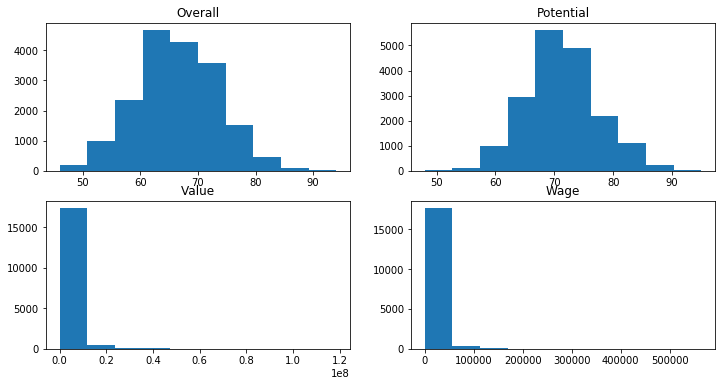

In [16]:
# look at histogram
fig, axs = plt.subplots(2,2)
fig.set_size_inches (12, 6)
axs[0, 0].hist(df.Overall)
axs[0, 0].set_title('Overall')
axs[0, 1].hist(df.Potential)
axs[0, 1].set_title('Potential')
axs[1, 0].hist(df.Value)
axs[1, 0].set_title('Value')
axs[1, 1].hist(df.Wage)
axs[1, 1].set_title('Wage')
#plt.show()
plt.savefig('hist.png')

In [17]:
df[['Overall', 'Potential', 'Value', 'Wage']].describe()

,Overall,Potential,Value,Wage
count,18147.000000,18147.000000,1.814700e+04,18147.000000
mean,66.253926,71.324076,2.417729e+06,9759.023530
std,6.913320,6.132286,5.602826e+06,22030.250349
min,46.000000,48.000000,0.000000e+00,0.000000
25%,62.000000,67.000000,3.000000e+05,1000.000000
50%,66.000000,71.000000,6.750000e+05,3000.000000
75%,71.000000,75.000000,2.000000e+06,9000.000000
max,94.000000,95.000000,1.185000e+08,565000.000000


* Variables Overall and Potential appear to be close to normal distribution.
* Value and Wage (both in monetary values) have extremely right skewed distrubution. There are 0s and low wage at low end of the distribution.

Now let's take a look at these variables vs. player positions using seaborn violin plots

Text(0.5, 1.0, 'Overall')

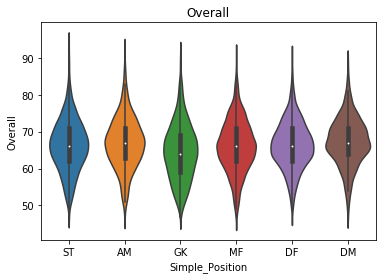

In [18]:
sns.violinplot(x=df.Simple_Position, y=df.Overall)
plt.title('Overall')

Text(0.5, 1.0, 'Potential')

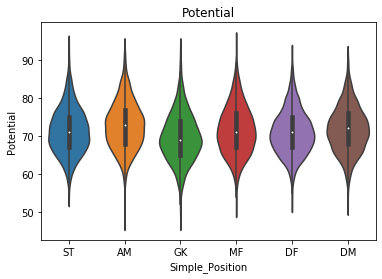

In [19]:
sns.violinplot(x=df.Simple_Position, y=df.Potential)
plt.title('Potential')

Text(0.5, 1.0, 'Value')

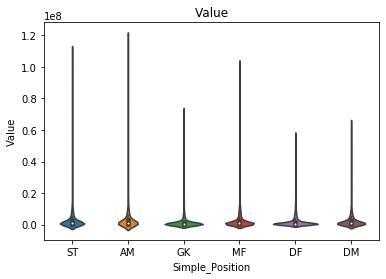

In [20]:
sns.violinplot(x=df.Simple_Position, y=df.Value)
plt.title('Value')

Text(0.5, 1.0, 'Wage')

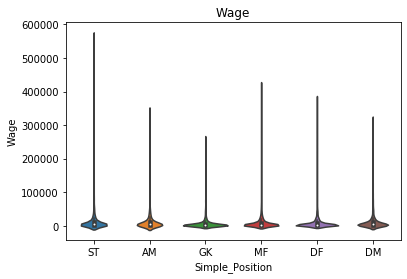

In [21]:
sns.violinplot(x=df.Simple_Position, y=df.Wage)
plt.title('Wage')

* All these variables do not show significant difference against player positions, although attacking positions are a little more valued than defending positions.

Look at these variables against Age and relationship among themselves.

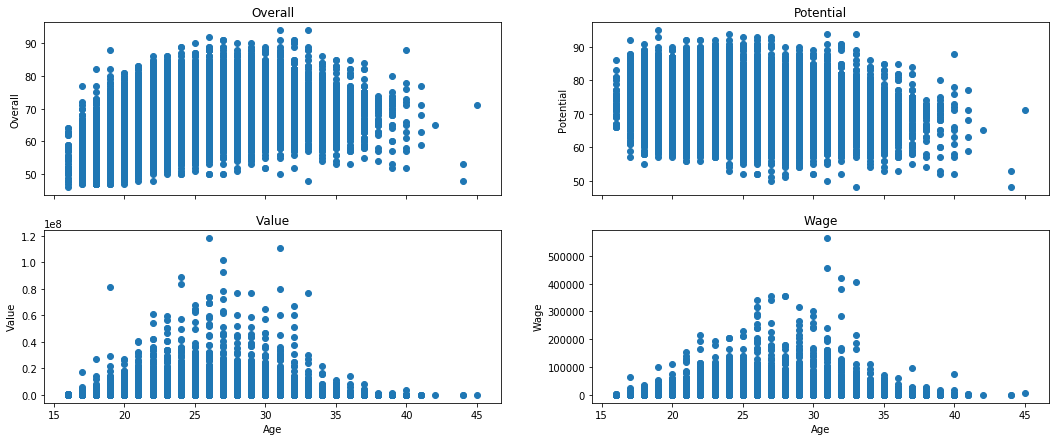

In [22]:
fig, axs = plt.subplots(2,2, sharex=True)
fig.set_size_inches (18, 7)
axs[0, 0].scatter(df.Age, df.Overall)
axs[0, 0].set_title('Overall')
axs[0, 0].set_ylabel('Overall')
axs[0, 1].scatter(df.Age, df.Potential)
axs[0, 1].set_title('Potential')
axs[0, 1].set_ylabel('Potential')
axs[1, 0].scatter(df.Age, df.Value)
axs[1, 0].set_title('Value')
axs[1, 0].set_ylabel('Value')
axs[1, 0].set_xlabel('Age')
axs[1, 1].scatter(df.Age, df.Wage)
axs[1, 1].set_title('Wage')
axs[1, 1].set_ylabel('Wage')
axs[1, 1].set_xlabel('Age')

plt.show()

* Overall tends to go up with the increase of Age to a little above 30 years old, and then starts to go down
* Potential has a general trend to go down with the increase of Age.
* Value and Wage peaks around 27 years old, with some exceptions due to several super stars.

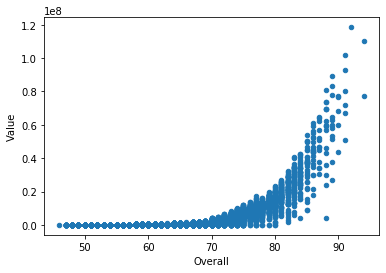

In [23]:
df.plot(kind='scatter', x='Overall', y='Value')

Above scatter plot shows that monetary value stays low with Overall below ~70, then it starts to increase exponentially.

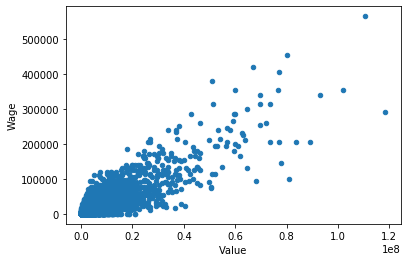

In [24]:
df.plot(kind='scatter', x='Value', y='Wage')

Not surprisingly, Wage and Value (both in monetary term) appear to have a positive linear relationship. There is still a lot of variation in Wage at the same Value level due to many other factors (contract, club, age, etc.).

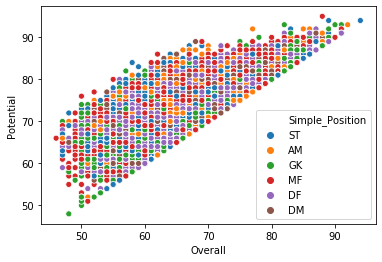

In [25]:
sns.scatterplot(data=df, x='Overall', y='Potential', hue='Simple_Position')

Interestingly the Potential vs. Overall scatter plot shows a clear linear boundary.

Text(0, 0.5, 'Potential - Overall')

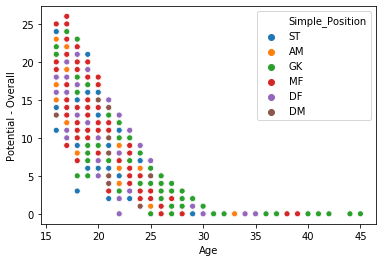

In [26]:
pot_minus_overall = df.Potential - df.Overall
sns.scatterplot(x=df.Age, y=pot_minus_overall, hue=df.Simple_Position)
plt.ylabel('Potential - Overall')

* The calculation of (Potential - Overall) shows that Potential is lower-bounded by Overall, i.e. Potential equals Overall plus some positive value.
* (Potential - Overall) vs. Age scatter plot (shown above) shows that the positive difference decreases with Age, and goes down to 0 at 31 years old and beyond.

### Based on above EDA, Overall is the best response/prediction variable.

Now let's take a look at Overall vs. other variables

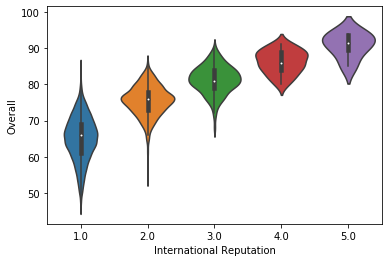

In [27]:
sns.violinplot(x=df['International Reputation'], y=df.Overall)

Not surprisingly, the higher the International Reputation, the higher the Overall.

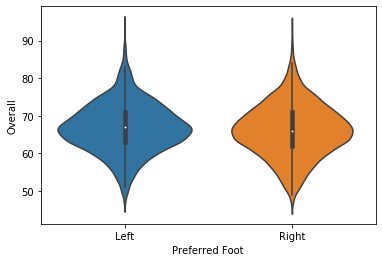

In [28]:
sns.violinplot(x=df['Preferred Foot'], y=df.Overall)

Left or Right foot does not show significant difference in impact of Overall.

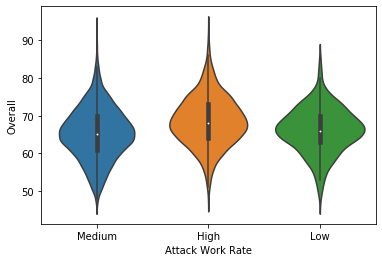

In [29]:
sns.violinplot(x=df['Attack Work Rate'], y=df.Overall)

The higher the Attack Work Rate, the higher the Overall. Mean difference is not very large.

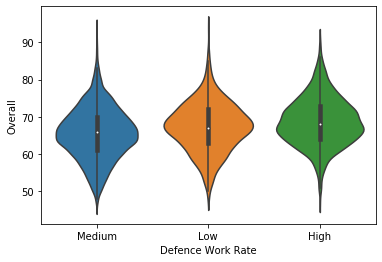

In [30]:
sns.violinplot(x=df['Defence Work Rate'], y=df.Overall)

Defence Work Rate does not show clear impact on Overall.

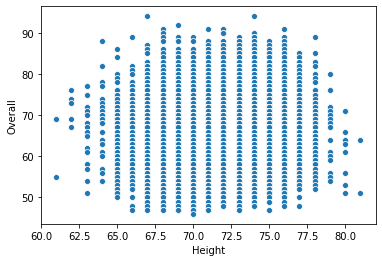

In [31]:
sns.scatterplot(data=df, x='Height', y='Overall')

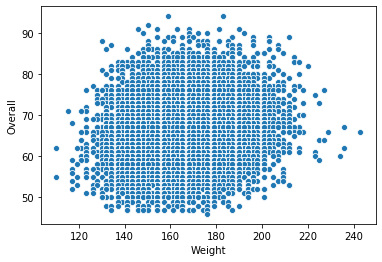

In [32]:
sns.scatterplot(data=df, x='Weight', y='Overall')

Height does not show significant correlation to Overall, while Weight appears to show a small positive correlation to Overall.

Text(0.5, 0, 'Sum of Skill Scores')

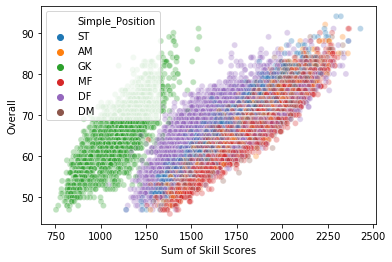

In [33]:
col_start = list(df.columns).index('Crossing')
col_end = list(df.columns).index('GKReflexes')
df_skills = df.iloc[:, col_start:col_end+1]
sum_skills = df_skills.sum(axis=1)
sns.scatterplot(x=sum_skills, y=df.Overall, hue=df.Simple_Position, alpha=0.3)
plt.xlabel('Sum of Skill Scores')

Text(0, 0.5, 'Sum of Skill Scores')

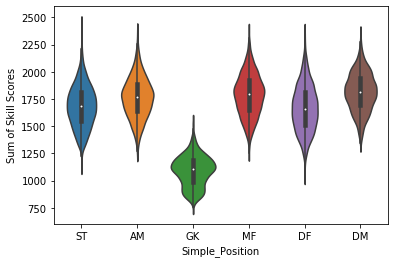

In [34]:
sns.violinplot(x=df.Simple_Position, y=sum_skills)
plt.ylabel('Sum of Skill Scores')

We calculated sum of all 34 skill scores like Crossing, Dribbling, Agility, GKReflexes, etc. Scatter and violin plots above clearly shows that GK (goal keeper) stands out with lower sum of scores.

## Modeling

In [35]:
from time import time
#from sklearn.preprocessing import CategoricalEncoder
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib     # for saving the model for future use

C:\Users\kevin\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [36]:
y = df.Overall
X = df.drop(['Name', 'Nationality', 'Overall', 'Potential', 'Value', 'Wage'], axis=1)

In [37]:
# handle categorical variables
X = pd.get_dummies(X, drop_first=True)

In [38]:
X.head()

,Age,International Reputation,Weak Foot,Skill Moves,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,...,Preferred Foot_Right,Attack Work Rate_Low,Attack Work Rate_Medium,Defence Work Rate_Low,Defence Work Rate_Medium,Simple_Position_DF,Simple_Position_DM,Simple_Position_GK,Simple_Position_MF,Simple_Position_ST
0,31,5.0,4.0,4.0,67.0,159.0,84.0,95.0,70.0,90.0,...,0,0,1,0,1,0,0,0,0,1
1,33,5.0,4.0,5.0,74.0,183.0,84.0,94.0,89.0,81.0,...,1,0,0,1,0,0,0,0,0,1
2,26,5.0,5.0,5.0,69.0,150.0,79.0,87.0,62.0,84.0,...,1,0,0,0,1,0,0,0,0,0
3,27,4.0,3.0,1.0,76.0,168.0,17.0,13.0,21.0,50.0,...,1,0,1,0,1,0,0,1,0,0
4,27,4.0,5.0,4.0,71.0,154.0,93.0,82.0,55.0,92.0,...,1,0,0,0,0,0,0,0,1,0


In [39]:
# split 20% for test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 19)

In [40]:
# Utility function to report best scores (use neg_mean_squared_error)
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean neg MSE: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [41]:
# create instances of decision tree and random forest regressors
dt_reg = DecisionTreeRegressor()
rf_reg = RandomForestRegressor()

In [42]:
# define parameter distribution for decision tree
param_dist_dt = {"max_depth": sp_randint(10, 41),
                 "min_samples_split": sp_randint(10, 41)
                }

In [43]:
n_iter_search_dt = 500
random_search_dt = RandomizedSearchCV(dt_reg, param_distributions=param_dist_dt,
                                   n_iter=n_iter_search_dt, cv=5, iid=False, scoring='neg_mean_squared_error', n_jobs=-1)

start = time()
random_search_dt.fit(X_train, y_train)
print("Decision Tree RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search_dt))
report(random_search_dt.cv_results_)

Decision Tree RandomizedSearchCV took 119.33 seconds for 500 candidates parameter settings.
Model with rank: 1
Mean neg MSE: -4.493 (std: 0.158)
Parameters: {'max_depth': 21, 'min_samples_split': 36}

Model with rank: 2
Mean neg MSE: -4.494 (std: 0.158)
Parameters: {'max_depth': 37, 'min_samples_split': 35}

Model with rank: 3
Mean neg MSE: -4.496 (std: 0.169)
Parameters: {'max_depth': 38, 'min_samples_split': 34}



In [44]:
# define parameter distribution for random forest
param_dist_rf = {"n_estimators": sp_randint(100, 501),
                 "max_depth": sp_randint(10, 41),
                 "max_features": sp_randint(6, 45),
                 "min_samples_split": sp_randint(2, 41)
                }

In [45]:
n_iter_search_rf = 300
random_search_rf = RandomizedSearchCV(rf_reg, param_distributions=param_dist_rf,
                                   n_iter=n_iter_search_rf, cv=5, iid=False, scoring='neg_mean_squared_error', n_jobs=-1)

start = time()
random_search_rf.fit(X_train, y_train)
print("Decision Tree RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search_rf))
report(random_search_rf.cv_results_)

Decision Tree RandomizedSearchCV took 6366.63 seconds for 300 candidates parameter settings.
Model with rank: 1
Mean neg MSE: -1.493 (std: 0.059)
Parameters: {'max_depth': 39, 'max_features': 10, 'min_samples_split': 3, 'n_estimators': 469}

Model with rank: 2
Mean neg MSE: -1.505 (std: 0.049)
Parameters: {'max_depth': 39, 'max_features': 11, 'min_samples_split': 3, 'n_estimators': 330}

Model with rank: 3
Mean neg MSE: -1.507 (std: 0.058)
Parameters: {'max_depth': 37, 'max_features': 10, 'min_samples_split': 3, 'n_estimators': 237}



In [46]:
# calculate mse on setaside test data using best Decision Tree model
mse_dt = mean_squared_error(y_test, random_search_dt.best_estimator_.predict(X_test))
print('Decision Tree MSE on test data: ', mse_dt)

Decision Tree MSE on test data:  4.237782855189378


In [47]:
# calculate mse on setaside test data using best Random Forest model
mse_rf = mean_squared_error(y_test, random_search_rf.best_estimator_.predict(X_test))
print('Random Forest MSE on test data: ', mse_rf)

Random Forest MSE on test data:  1.4029484621431438


In [48]:
# save models to files
dt_filename = 'finalized_decision_tree_model.sav'
joblib.dump(random_search_dt, dt_filename)

rf_filename = 'finalized_random_forest_model.sav'
joblib.dump(random_search_rf, rf_filename)

['finalized_random_forest_model.sav']

Text(0.5, 1.0, 'Decision Tree Feature Importance Plot')

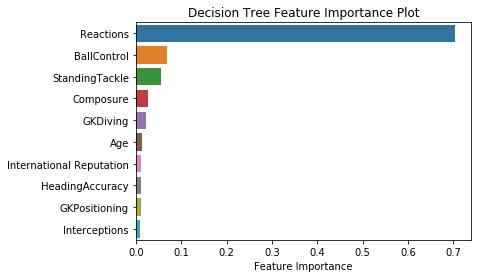

In [92]:
# for Decision Tree, plot first 10 most important features
dt_feature_importance = dict(zip(X.columns, random_search_dt.best_estimator_.feature_importances_))
dt_sorted_feature_importance = sorted(dt_feature_importance.items(), key=lambda kv: kv[1], reverse=True)
x_plot_dt = list(zip(*dt_sorted_feature_importance))[0]
y_plot_dt = list(zip(*dt_sorted_feature_importance))[1]
sns.barplot(y=list(x_plot_dt)[:10], x=list(y_plot_dt)[:10], orient='h')
plt.xlabel('Feature Importance')
plt.title('Decision Tree Feature Importance Plot')

Text(0.5, 1.0, 'Random Forest Feature Importance Plot')

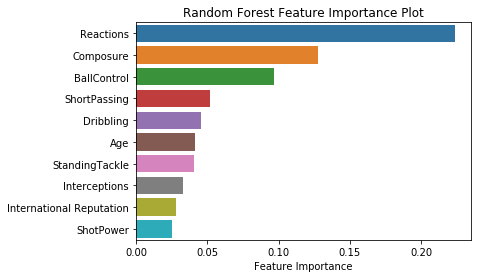

In [93]:
# for Random Forest, plot first 10 most important features
rf_feature_importance = dict(zip(X.columns, random_search_rf.best_estimator_.feature_importances_))
rf_sorted_feature_importance = sorted(rf_feature_importance.items(), key=lambda kv: kv[1], reverse=True)
x_plot_rf = list(zip(*rf_sorted_feature_importance))[0]
y_plot_rf = list(zip(*rf_sorted_feature_importance))[1]
sns.barplot(y=list(x_plot_rf)[:10], x=list(y_plot_rf)[:10], orient='h')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance Plot')

## Modeling Results:

* Random Forest performs better than Decision Tree regressor.
  * Decision Tree generated mse of 4.24 on held-out test data
  * Random Forest generated mse of 1.40 on held-out test data
* Both regressors have 7 out 10 most important predictors overlapping, which are scores for Reations, Composure, Ball Control, Standing Tackle, Interceptions, plus Age and International Reputation.